In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import pandas_datareader as web

In [2]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [27]:
#load data
import yfinance as yf

company = 'META'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
data = yf.download(company, start = start,  end = end)


print(data)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-05-18   42.049999   45.000000   38.000000   38.230000   38.230000   
2012-05-21   36.529999   36.660000   33.000000   34.029999   34.029999   
2012-05-22   32.610001   33.590000   30.940001   31.000000   31.000000   
2012-05-23   31.370001   32.500000   31.360001   32.000000   32.000000   
2012-05-24   32.950001   33.209999   31.770000   33.029999   33.029999   
...                ...         ...         ...         ...         ...   
2019-12-24  206.300003  206.789993  205.000000  205.119995  205.119995   
2019-12-26  205.570007  207.820007  205.309998  207.789993  207.789993   
2019-12-27  208.669998  208.929993  206.589996  208.100006  208.100006   
2019-12-30  207.860001  207.899994  203.899994  204.410004  204.410004   
2019-12-31  204.000000  205.559998  203.600

In [29]:
#prepare trainig data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [30]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
#build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))#prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 21s 113ms/step - loss: 0.0266
Epoch 2/25
59/59 [==============================] - 7s 122ms/step - loss: 0.0042
Epoch 3/25
59/59 [==============================] - 7s 120ms/step - loss: 0.0036
Epoch 4/25
59/59 [==============================] - 7s 124ms/step - loss: 0.0042
Epoch 5/25
59/59 [==============================] - 7s 124ms/step - loss: 0.0033
Epoch 6/25
59/59 [==============================] - 7s 122ms/step - loss: 0.0031
Epoch 7/25
59/59 [==============================] - 7s 123ms/step - loss: 0.0030
Epoch 8/25
59/59 [==============================] - 6s 95ms/step - loss: 0.0029
Epoch 9/25
59/59 [==============================] - 6s 96ms/step - loss: 0.0027
Epoch 10/25
59/59 [==============================] - 6s 97ms/step - loss: 0.0028
Epoch 11/25
59/59 [==============================] - 8s 143ms/step - loss: 0.0028
Epoch 12/25
59/59 [==============================] - 8s 136ms/step - loss: 0.0032
Epoch 13/25
59/59 [========

In [32]:
#testing the model accuracy on existing data
#prepare test data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%%**********************]  1 of 1 completed


In [33]:
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [34]:
#make predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

30/30 [==============================] - 3s 32ms/step


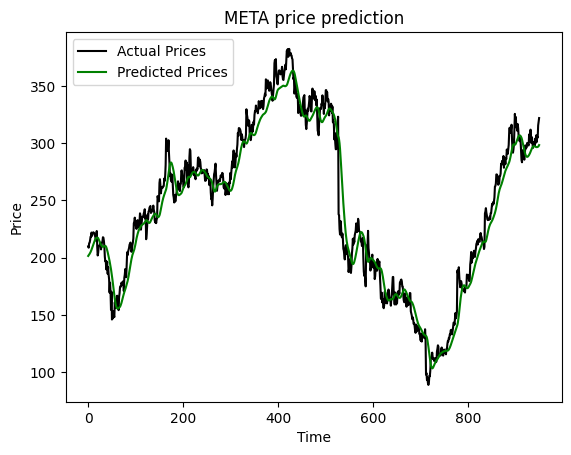

In [35]:
#plot test predictions
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{company} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [36]:
#predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 2s 2s/step
[[299.45468]]
